# Clustering and Classification Analysis on GA data set
1. Data Exploration
2. Classification Algorithms
3. Further Analysis based on outputs of Classification Algorithms

In [9]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing
import plotly.plotly as py
import plotly.figure_factory as ff

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import graphviz
import seaborn as sns; sns.set()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn import cluster
from sklearn import manifold

#Machine Learning Model
#Common Model Algorithms
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble
#For xgboost
import xgboost as xgb

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import random_projection

#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


%matplotlib inline

## Data Exploration

In [4]:
#Read in normalized features
df_normed = pd.read_csv('/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data/GA_data/normalized_all_GA_simple_attributes.csv', index_col = 0)

- **Final Shape: (56452, 35).**
- **Number of initial networks for GA: 56452.**
- **Number of features: 35 - 3 = 32 (Excluding "initial_accuracy", "final_accuracy", and "geaneology")**

Text(0.5, 0, 'Accuracy')

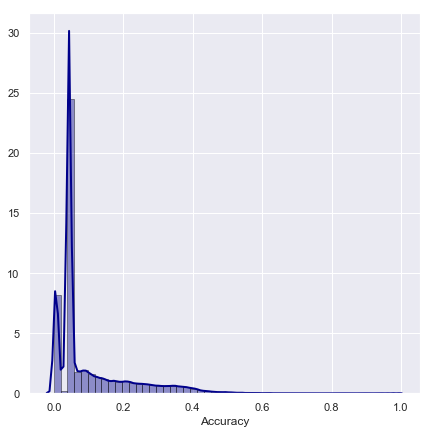

In [3]:
#histogram
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df_normed["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);
fig1.set_xlabel("Accuracy")
#plt.savefig('Accuracy_distribution_GA.png')

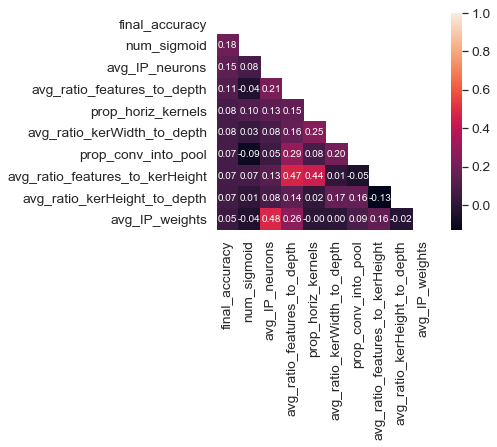

In [110]:
#final_accuracy correlation matrix
corrmat = df_normed.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'final_accuracy')['final_accuracy'].index
cm = np.corrcoef(df_normed[cols].values.T)
sns.set(font_scale=1.25)
mask = np.zeros_like(cm)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    # display a correlation heatmap
    ax = sns.heatmap(cm, cbar=True, annot=True, square=True, 
                     fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, 
                     xticklabels=cols.values, mask=mask)
plt.show()

### Select out the peaks

In [99]:
df_normed.shape[0]

56452

In [104]:
(56452-22824)/56452

0.5956919152554383

In [100]:
df_normed['final_accuracy'].describe()

count    56452.000000
mean         0.096127
std          0.108660
min          0.000000
25%          0.043450
50%          0.043450
75%          0.119613
max          0.982201
Name: final_accuracy, dtype: float64

In [102]:
df_normed2 = df_normed[df_normed['final_accuracy'] >= 0.043451] #Good threshold 0.04346
print(df_normed2.shape)

(22824, 35)


Text(0.5, 1.0, 'Distribution of final_accuracy')

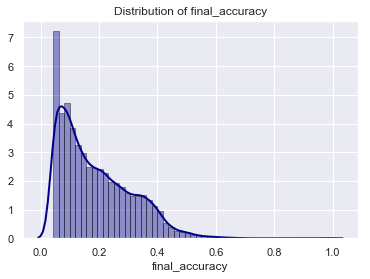

In [68]:
#histogram
fig1 = sns.distplot(df_normed2["final_accuracy"],
                    hist=True, kde=True, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=True);
fig1.set_title("Distribution of final_accuracy")

### Selection ends 

## PCA

### 3D

In [69]:
X_normed = df_normed.drop(['initial_accuracy', 'final_accuracy', 'genealogy'],axis=1)

In [70]:
pca = PCA(3)
projected = pca.fit_transform(X_normed)

#Check
print(X_normed.shape)
print(projected.shape)

(56452, 32)
(56452, 3)


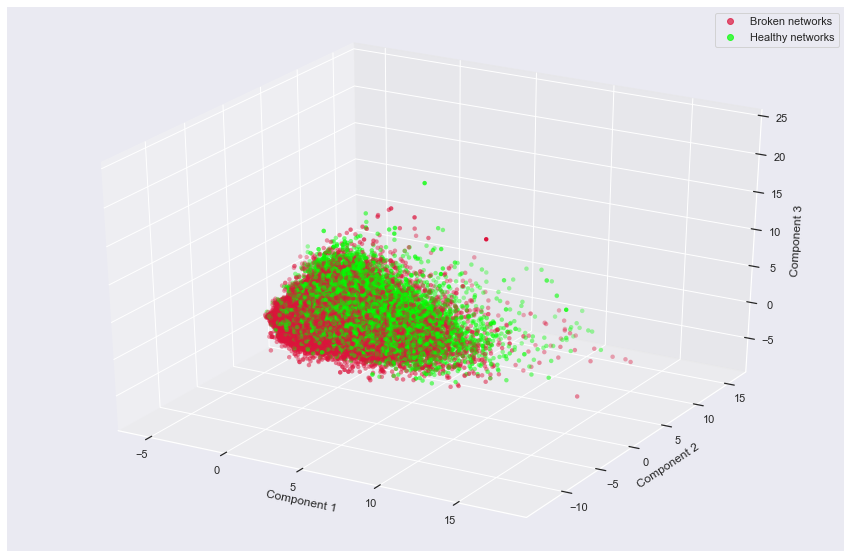

In [72]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.04346 else 'lime' for x in df_normed['final_accuracy']]

#Plot the PCA analysis for GA
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected[:,0], projected[:,1], projected[:,2], c=colors, edgecolor='none',
           marker='o')

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.savefig('PCD-3D-GA.png')

plt.show()

### 2D

(56452, 32)
(56452, 2)


Text(102.875, 0.5, 'Component 2')

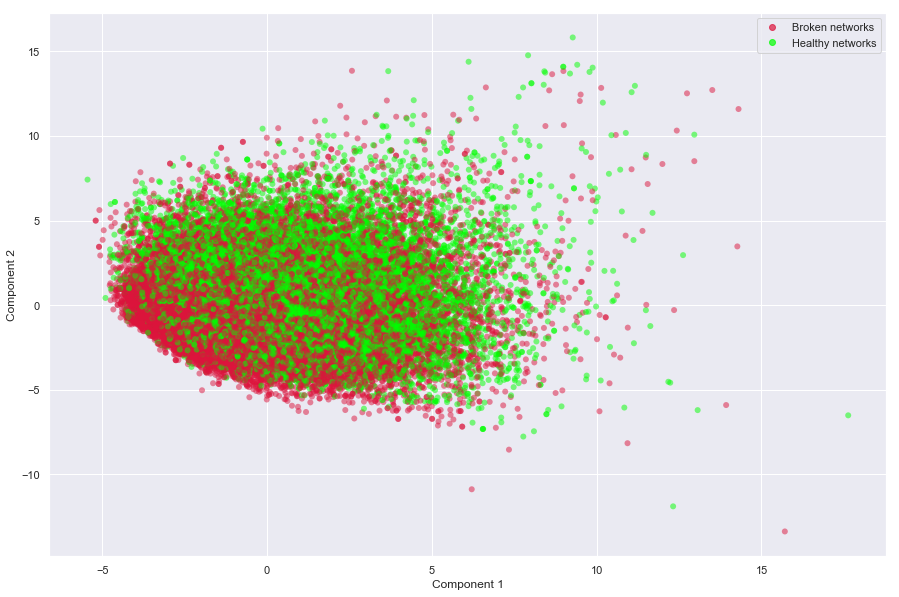

In [73]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected1 = pca.fit_transform(X_normed)

#Check
print(X_normed.shape)
print(projected1.shape)

fig = plt.figure(figsize=[15,10])
plt.scatter(projected1[:, 0], projected1[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------
plt.savefig('PCD-2D-GA.png')

plt.xlabel('Component 1')
plt.ylabel('Component 2')

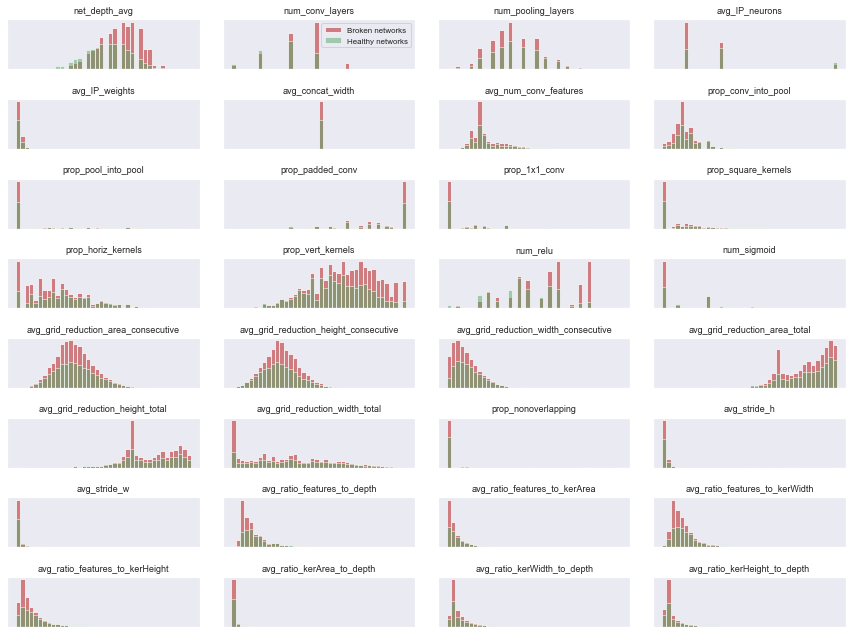

In [74]:
#Plot Histogram of distribution

fig,axes = plt.subplots(8,4, figsize=(12, 9)) # 4 columns each containing 8 figures, total 32 features

very_low_acc = X_normed[df_normed['final_accuracy'] < 0.045] # define very low accuracy

normal_acc = X_normed[df_normed['final_accuracy'] >= 0.045] # define normal accuracy

ax = axes.ravel() # flat axes with numpy ravel

for i in range(32):
  _,bins = np.histogram(X_normed.iloc[:,i], bins=40)
  ax[i].hist(very_low_acc.iloc[:,i], bins=bins,color='r',alpha=.7) # red color for very low accuracy class
  ax[i].hist(normal_acc.iloc[:,i], bins=bins,color='g',alpha=0.5) # alpha is low for transparency in the overlapped region 
  ax[i].set_title(X_normed.columns[i],fontsize=9)
  ax[i].axes.get_xaxis().set_visible(False) # the x-axis co-ordinates are not so useful, as we just want to look how well separated the histograms are
  ax[i].set_yticks(())
    
ax[1].legend(['Broken networks','Healthy networks'],loc='best',fontsize=8)

plt.tight_layout()# let's make good plots

plt.savefig('Dist-atrributes.png')

plt.show()

In [2]:
#More detailed distribution plot here

In [5]:
df1 = df_normed[df_normed['final_accuracy'] < 0.045]
df2 = df_normed[df_normed['final_accuracy'] >= 0.045]

In [17]:
#net_depth_avg
#py.iplot(ff.create_distplot([df1['net_depth_avg'], df2['net_depth_avg']],
                            #group_labels = ['broken networks', 'healthy networks'], bin_size=.26),
                            #filename='distplot with pandas')

In [18]:
#avg_ratio_features_to_kerWidth
#py.iplot(ff.create_distplot([df1['avg_ratio_features_to_kerWidth'], df2['avg_ratio_features_to_kerWidth']],
                            #group_labels = ['broken networks', 'healthy networks'], bin_size=.1),
                            #filename='distplot with pandas')

In [26]:
#num_relu
#py.iplot(ff.create_distplot([df1['num_relu'], df2['num_relu']],
                            #group_labels = ['broken networks', 'healthy networks'], bin_size=.6),
                            #filename='distplot with pandas')

In [12]:
#avg_ratio_features_to_depth
#py.iplot(ff.create_distplot([df1['avg_ratio_features_to_depth'], df2['avg_ratio_features_to_depth']],
                            #group_labels = ['broken networks', 'healthy networks'], bin_size=.23),
                            #filename='distplot with pandas')

In [5]:
X_normed = df_normed[['net_depth_avg','avg_ratio_features_to_kerWidth','num_relu','avg_ratio_features_to_depth']]

In [6]:
pca = PCA(3)
projected = pca.fit_transform(X_normed)

#Check
print(X_normed.shape)
print(projected.shape)

(56452, 4)
(56452, 3)


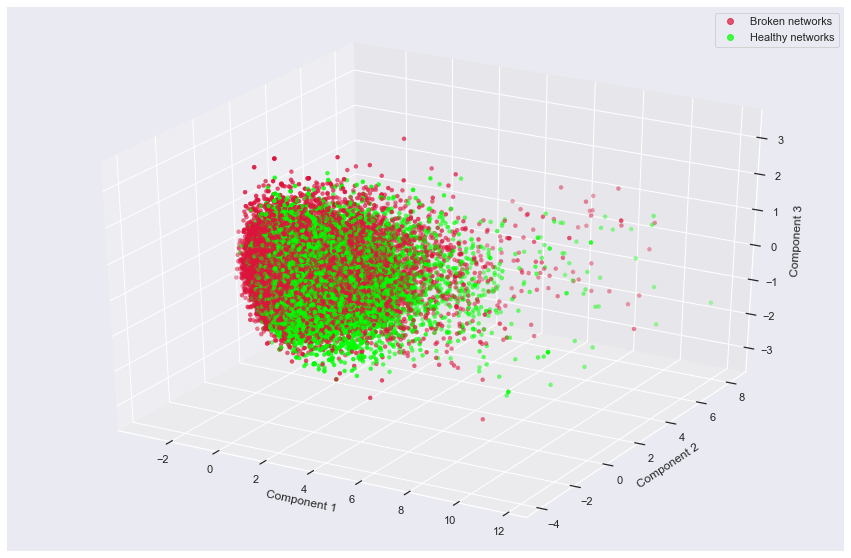

In [17]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.045 else 'lime' for x in df_normed['final_accuracy']]

#Plot the PCA analysis for GA
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected[:,0], projected[:,1], projected[:,2], c=colors, edgecolor='none',
           marker='o')

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()

(56452, 4)
(56452, 2)


Text(108.875, 0.5, 'Component 2')

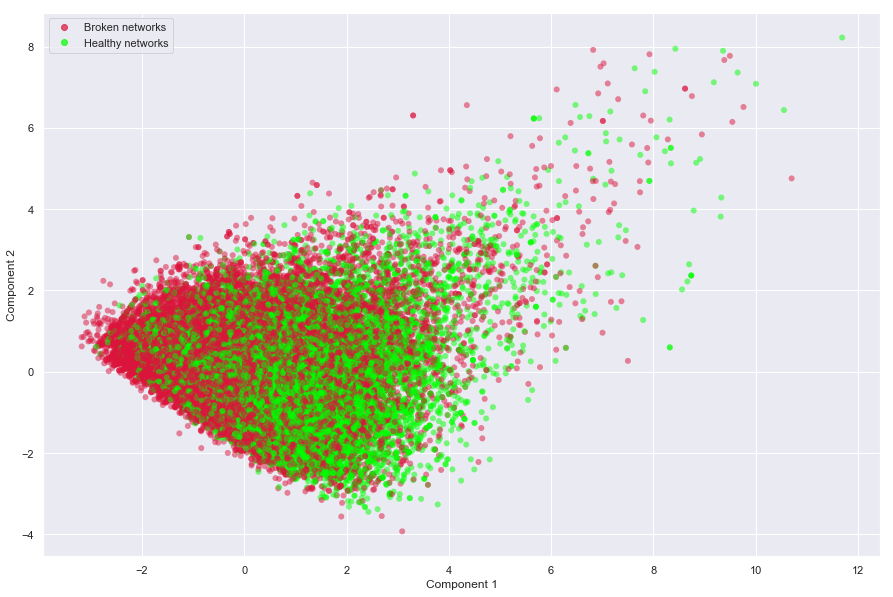

In [18]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected1 = pca.fit_transform(X_normed)

#Check
print(X_normed.shape)
print(projected1.shape)

fig = plt.figure(figsize=[15,10])
plt.scatter(projected1[:, 0], projected1[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------
plt.savefig('PCD-2D-GA.png')

plt.xlabel('Component 1')
plt.ylabel('Component 2')

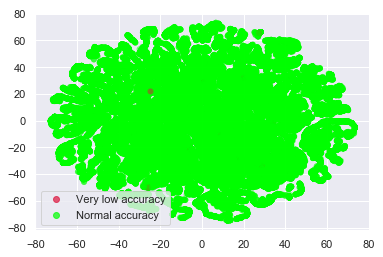

In [7]:
#Try some none-linearity embeddings
tsne = TSNE()

trans = tsne.fit_transform(X_normed)

#Get the colors based on final_accuracy
colors = ['crimson' if row < 0.0045 else 'lime' for row in df_normed['final_accuracy']]

#Plot the transformed data
plt.scatter(trans[:, 0], trans[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Very low accuracy', alpha = 0.7)
high_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Normal accuracy', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, high_accuracy_legend])
# ----------------------

In [8]:
#Try random projection

In [12]:
transformer = random_projection.GaussianRandomProjection(n_components=2)
X1 = transformer.fit_transform(X_normed)
print("New shape: ", X1.shape)

New shape:  (56452, 2)


Text(0, 0.5, 'Component 2')

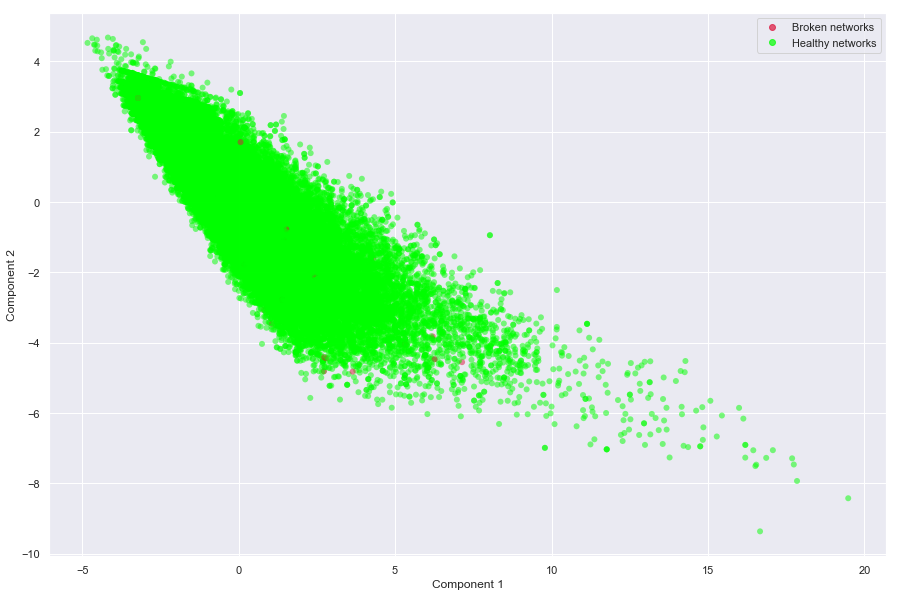

In [13]:
fig = plt.figure(figsize=[15,10])
plt.scatter(X1[:, 0], X1[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [14]:
#Try MDS

In [17]:
embedding = MDS(n_components=3)
X2 = embedding.fit_transform(X_normed)

print("Old shape: ", X_normed.shape)
print("New shape: ", X2.shape)

KeyboardInterrupt: 

## Different classification algorithms

In [73]:
#Prepare the data

In [77]:
df = pd.read_csv('/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data/GA_data/all_GA_simple_attributes.csv', index_col = 0)

In [78]:
df = df.dropna()

In [79]:
df.head()

,initial_accuracy,final_accuracy,genealogy,net_depth_avg,num_conv_layers,num_pooling_layers,avg_IP_neurons,avg_IP_weights,avg_concat_width,avg_num_conv_features,...,prop_nonoverlapping,avg_stride_h,avg_stride_w,avg_ratio_features_to_depth,avg_ratio_features_to_kerArea,avg_ratio_features_to_kerWidth,avg_ratio_features_to_kerHeight,avg_ratio_kerArea_to_depth,avg_ratio_kerWidth_to_depth,avg_ratio_kerHeight_to_depth
00001_00000_00000,0.0071,0.04345,1,10.000000,12,6,100.666667,9.704235e+06,2.166667,24.0,...,0.0,1.555556,1.0,11.288254,1.080026,8.000000,3.240079,12.395833,1.562500,4.131944
00001_00001_00012,0.0071,0.04345,1,8.000000,9,3,100.666667,1.840597e+06,2.166667,28.0,...,0.0,2.166667,1.0,16.316667,3.598087,15.555556,6.751933,15.611111,1.425926,5.981481
00001_00000_02062,0.0071,0.07075,1,9.666667,12,5,100.666667,2.062293e+06,2.166667,40.0,...,0.0,2.117647,1.0,24.088254,3.163360,18.000000,5.990079,10.861111,1.381944,3.861111
00001_00000_01182,0.0071,0.04345,1,9.666667,12,8,119.000000,3.561184e+07,2.166667,39.0,...,0.0,1.600000,1.0,14.842857,6.212454,13.000000,18.637363,13.937500,1.562500,4.645833
00002_00000_00001,0.0071,0.00690,2,10.000000,12,6,100.666667,9.704235e+06,2.166667,24.0,...,0.0,1.555556,1.0,11.288254,1.080026,8.000000,3.240079,12.395833,1.562500,4.131944


In [80]:
#Select the features and dependent variable
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = pd.Series([0 if x < 0.04346 else 1 for x in df['final_accuracy']]) #dependent variable

In [81]:
#Divide train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

In [82]:
((y_test.shape[0] - y_test.sum())/y_test.shape[0])

0.5964927818616598

In [92]:
#Scale the data set (Careful with data leakage)
scaler = preprocessing.StandardScaler().fit(X_train)

#Train and test set has to go through similar transformation
X1_train = scaler.transform(X_train)

X1_test = scaler.transform(X_test)

**GOAL:** Get more than 0.61

### K-mean Classifier

In [93]:
km = KNeighborsClassifier(n_neighbors=2)
y_pred_km = km.fit(X1_train, y_train).predict(X1_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_km).sum()))

#Print accuracy
accuracy_km = ((X_test.shape[0]-(y_test != y_pred_km).sum())/X_test.shape[0])
print("Accuracy : %f"% accuracy_km)

#Average cross validation score
scores_km = cross_val_score(km, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_km.mean())

Number of mislabeled points out of a total 11291 points : 3902
Accuracy : 0.654415
Average cross validation score: 0.645893


### Naive Bayes

#### Gaussian NB

In [28]:
gnb = GaussianNB()
y_pred_nb = gnb.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_nb).sum()))

#Average cross validation score
scores_nb = cross_val_score(gnb, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_nb.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Gaussian Naive Bayes",
                                 "Cross-validation scores": scores_nb.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 4118
Average cross validation score: 0.629152


#### Bernoulli

In [151]:
bnb = BernoulliNB()
y_pred_bnb = bnb.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_bnb).sum()))

#Print accuracy
accuracy_bnb = ((X_test.shape[0]-(y_test != y_pred_bnb).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_bnb)

#Average cross validation score
scores_bnb = cross_val_score(bnb, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_bnb.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Bernoulli Naive Bayes",
                                 "Accuracy on test set": accuracy_bnb,
                                 "Cross-validation scores": scores_bnb.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 4127
Accuracy : 0.634488
Average cross validation score: 0.624864


### Decision Tree

In [153]:
dt = tree.DecisionTreeClassifier(random_state = 0)
y_pred_dt = dt.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_dt).sum()))

#Print accuracy
accuracy_dt = ((X_test.shape[0]-(y_test != y_pred_dt).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_dt)

#Average cross validation score
scores_dt = cross_val_score(dt, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_dt.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Decision Tree",
                                 "Accuracy on test set": accuracy_dt,
                                 "Cross-validation scores": scores_dt.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3919
Accuracy : 0.652909
Average cross validation score: 0.637442


In [20]:
#Prepare to plot tree
features = ['net_depth_avg', 'num_conv_layers', 'num_pooling_layers',
       'avg_IP_neurons', 'avg_IP_weights', 'avg_concat_width',
       'avg_num_conv_features', 'prop_conv_into_pool', 'prop_pool_into_pool',
       'prop_padded_conv', 'prop_1x1_conv', 'prop_square_kernels',
       'prop_horiz_kernels', 'prop_vert_kernels', 'num_relu', 'num_sigmoid',
       'avg_grid_reduction_area_consecutive',
       'avg_grid_reduction_height_consecutive',
       'avg_grid_reduction_width_consecutive', 'avg_grid_reduction_area_total',
       'avg_grid_reduction_height_total', 'avg_grid_reduction_width_total',
       'prop_nonoverlapping', 'avg_stride_h', 'avg_stride_w',
       'avg_ratio_features_to_depth', 'avg_ratio_features_to_kerArea',
       'avg_ratio_features_to_kerWidth', 'avg_ratio_features_to_kerHeight',
       'avg_ratio_kerArea_to_depth', 'avg_ratio_kerWidth_to_depth',
       'avg_ratio_kerHeight_to_depth']

target = 'group'

In [22]:
#Plot Tree
#dot_data = tree.export_graphviz(clf, out_file=None, feature_names=features, 
                                #class_names=target, filled=True, rounded=True,
                                #special_characters=True)  
#graph = graphviz.Source(dot_data)  

#graph 

### Support Vector Machine

#### Linear Kernel

In [155]:
li = SVC(gamma = 'auto', kernel = 'linear')
y_pred_li = li.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_li).sum()))

#Print accuracy
accuracy_li = ((X_test.shape[0]-(y_test != y_pred_li).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_li)

#Average cross validation score
scores_li = cross_val_score(li, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_li.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "SVM - Linear Kernel",
                                 "Accuracy on test set": accuracy_li,
                                 "Cross-validation scores": scores_li.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3679
Accuracy : 0.674165
Average cross validation score: 0.654201


#### Poly

In [157]:
poly = SVC(gamma = 'auto', kernel = 'poly')
y_pred_poly = poly.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_poly).sum()))

#Print accuracy
accuracy_poly = ((X_test.shape[0]-(y_test != y_pred_poly).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_poly)

#Average cross validation score
scores_poly = cross_val_score(poly, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_poly.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "SVM - Poly Kernel",
                                 "Accuracy on test set": accuracy_poly,
                                 "Cross-validation scores": scores_poly.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3788
Accuracy : 0.664512
Average cross validation score: 0.653262


#### Radial Basis Function Kernel

In [160]:
rbf = SVC(gamma = 'auto', kernel = 'rbf')
y_pred_rbf = rbf.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_rbf).sum()))

#Print accuracy
accuracy_rbf = ((X_test.shape[0]-(y_test != y_pred_rbf).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_rbf)

#Average cross validation score
scores_rbf = cross_val_score(rbf, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_rbf.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "SVM - Radial Basis Function Kernel",
                                 "Accuracy on test set": accuracy_rbf,
                                 "Cross-validation scores": scores_rbf.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3593
Accuracy : 0.681782
Average cross validation score: 0.664351


#### Sigmoid

In [30]:
clf_sig = SVC(gamma = 'auto', kernel = 'sigmoid')
y_pred_S = clf_sig.fit(X_train,y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_S).sum()))

#Print accuracy
print("Accuracy : %f"
      % ((X_test.shape[0]-(y_test != y_pred_S).sum())/X_test.shape[0]))

Number of mislabeled points out of a total 11291 points : 4645
Accuracy : 0.588610


### Random Forest

In [94]:
rf = RandomForestClassifier(n_estimators=1000,max_depth = None, random_state=0)
y_pred_rf = rf.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_rf).sum()))

#Print accuracy
accuracy_rf = ((X_test.shape[0]-(y_test != y_pred_rf).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_rf)

#Average cross validation score
scores_rf = cross_val_score(rf, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_rf.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Random Forest",
                                 "Accuracy on test set": accuracy_rf,
                                 "Cross-validation scores": scores_rf.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3159
Accuracy : 0.720220
Average cross validation score: 0.685253


NameError: name 'model_info' is not defined

In [163]:
model_info

,Model's Name,Accuracy on test set,Cross-validation scores
0,K-mean Classifier,0.654326,0.635725
1,Gaussian Naive Bayes,0.635285,0.629152
2,Bernoulli Naive Bayes,0.634488,0.624864
3,Decision Tree,0.652909,0.637442
4,SVM - Linear Kernel,0.674165,0.654201
5,SVM - Poly Kernel,0.664512,0.653262
6,SVM - Radial Basis Function Kernel,0.681782,0.664351
7,Random Forest,0.720397,0.688512


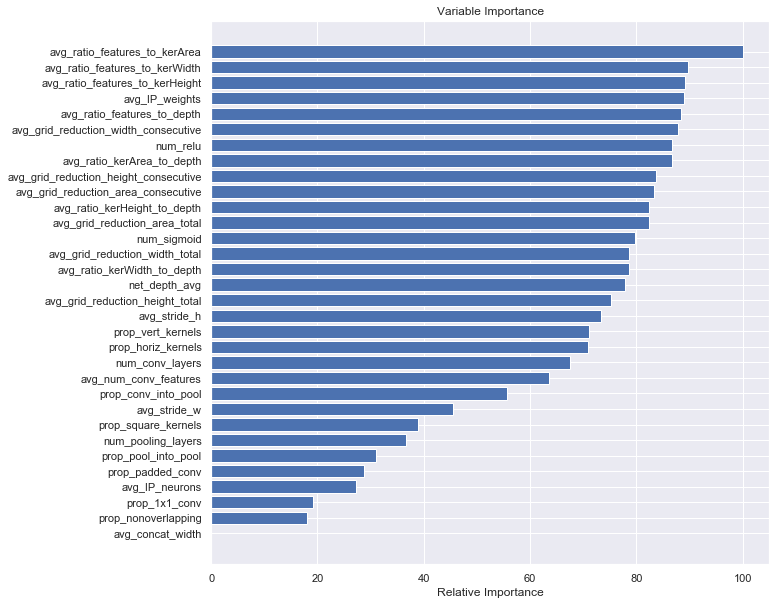

In [64]:
feature_importance = clf_rf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

Features_importance_rf = pd.DataFrame({'Feature':X_normed.columns,'Importance':feature_importance})

Sorted_Features_importance_rf = Features_importance_rf.sort_values(by=['Importance'])

pos = np.arange(Features_importance_rf.shape[0]) + .5

fig = plt.figure(figsize = [10,10])
plt.barh(pos, Sorted_Features_importance_rf['Importance'], align='center')
plt.yticks(pos, Sorted_Features_importance_rf['Feature'])
plt.xlabel('Relative Importance')
plt.show()

#### Random Forest on RandomTreeEmbeddings

In [71]:
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_tree_transformed = hasher.fit_transform(X_normed)

X_train_rf, X_test_rf, y_train_rf, y_test_rf = model_selection.train_test_split(X_tree_transformed, y, test_size = 0.2, random_state=0)

In [72]:
clf_rf1 = RandomForestClassifier(n_estimators=1000, max_depth = None, random_state=0)
y_pred_RF1 = clf_rf1.fit(X_train_rf,y_train_rf).predict(X_test_rf)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test_rf != y_pred_RF1).sum()))

#Print accuracy
print("Accuracy : %f"
      % ((X_test.shape[0]-(y_test_rf != y_pred_RF1).sum())/X_test.shape[0]))

#Average cross validation score
scores_rf1 = cross_val_score(clf_rf1, X_tree_transformed, y, cv=5)
print("Average cross validation score: %f" %scores_rf1.mean())

Number of mislabeled points out of a total 11291 points : 4115
Accuracy : 0.635550
Average cross validation score: 0.617993


#### Extremely Randomized Tree

In [164]:
ex = ExtraTreesClassifier(n_estimators=1000, random_state=0)
y_pred_ex = ex.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_ex).sum()))

#Print accuracy
accuracy_ex = ((X_test.shape[0]-(y_test != y_pred_ex).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_ex)

#Average cross validation score
scores_ex = cross_val_score(ex, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_ex.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Extremely Randomized Tree",
                                 "Accuracy on test set": accuracy_ex,
                                 "Cross-validation scores": scores_ex.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3195
Accuracy : 0.717031
Average cross validation score: 0.686830


In [65]:
#Leave analysis for later

#### Adaboost 

In [168]:
ada = AdaBoostClassifier(n_estimators=1000, random_state=0)
y_pred_ada = ada.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_ada).sum()))

#Print accuracy
accuracy_ada = ((X_test.shape[0]-(y_test != y_pred_ada).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_ada)

#Average cross validation score
scores_ada = cross_val_score(ada, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_ada.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Adaboost",
                                 "Accuracy on test set": accuracy_ada,
                                 "Cross-validation scores": scores_ada.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3532
Accuracy : 0.687184
Average cross validation score: 0.672694


#### Gradient Boosting Classifier

In [174]:
gra = GradientBoostingClassifier(n_estimators=1000, random_state=0)
y_pred_gra = gra.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_gra).sum()))

#Print accuracy
accuracy_gra = ((X_test.shape[0]-(y_test != y_pred_gra).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_gra)

#Average cross validation score
scores_gra = cross_val_score(gra, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_gra.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Gradient Boosting Classifier",
                                 "Accuracy on test set": accuracy_gra,
                                 "Cross-validation scores": scores_gra.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3466
Accuracy : 0.693030
Average cross validation score: 0.677069


### Logistic Regression

In [176]:
lr = LogisticRegressionCV(cv=5, random_state=0, multi_class='ovr')
y_pred_lr = lr.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_lr).sum()))

#Print accuracy
accuracy_lr = ((X_test.shape[0]-(y_test != y_pred_lr).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_lr)

#Average cross validation score
scores_lr = cross_val_score(lr, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_lr.mean())

#Add into infomation table
model_info = model_info.append([{"Model's Name": "Logisitic Regression",
                                 "Accuracy on test set": accuracy_lr,
                                 "Cross-validation scores": scores_lr.mean()}], ignore_index=True)

Number of mislabeled points out of a total 11291 points : 3683
Accuracy : 0.673811
Average cross validation score: 0.665768


### Perceptron

In [179]:
pc = Perceptron(tol=1e-3, random_state=0)
y_pred_pc = pc.fit(X_train, y_train).predict(X_test)

#Print output
print("Number of mislabeled points out of a total %d points : %d"   
      % (X_test.shape[0],(y_test != y_pred_pc).sum()))

#Print accuracy
accuracy_pc = ((X_test.shape[0]-(y_test != y_pred_pc).sum())/X_test.shape[0])
print("Accuracy : %f" % accuracy_pc)

#Average cross validation score
scores_pc = cross_val_score(pc, X_normed, y, cv=5)
print("Average cross validation score: %f" %scores_pc.mean())

Number of mislabeled points out of a total 11291 points : 4363
Accuracy : 0.613586
Average cross validation score: 0.617550


### Multi Layer Perceptron

In [9]:
mlp = MLPClassifier(hidden_layer_sizes= 10000, alpha=1, max_iter=1000)

#Average cross validation score
scores_mlp = cross_val_score(mlp, X_normed, y, cv=5)
print("Cross-validation scores: ", scores_mlp)
print("Average cross validation score: %f" %scores_mlp.mean())

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:568: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


Cross-validation scores:  [0.66061465 0.77486494 0.64588131 0.63498671 0.62099203]
Average cross validation score: 0.667468


## More Analysis on best-performing models

In [20]:
#Random Forest
#Extremely Randomized Tree
#Gradient Boosting Classifier

In [95]:
#For resusability

#Read in normalized features
df_normed = pd.read_csv('/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data/GA_data/normalized_all_GA_simple_attributes.csv', index_col = 0)

X_normed = df_normed.drop(['initial_accuracy', 'final_accuracy', 'genealogy'],axis=1)

df_normed['group'] = [0 if x < 0.045 else 1 for x in df_normed['final_accuracy']]
y = df_normed['group']

In [96]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_normed, y, test_size = 0.2, random_state=0)

In [97]:
#Scale the data set (Careful with data leakage)
scaler = preprocessing.StandardScaler().fit(X_train)

#Train and test set has to go through similar transformation
X1_train = scaler.transform(X_train)

X1_test = scaler.transform(X_test)

Accuracy : 0.719865


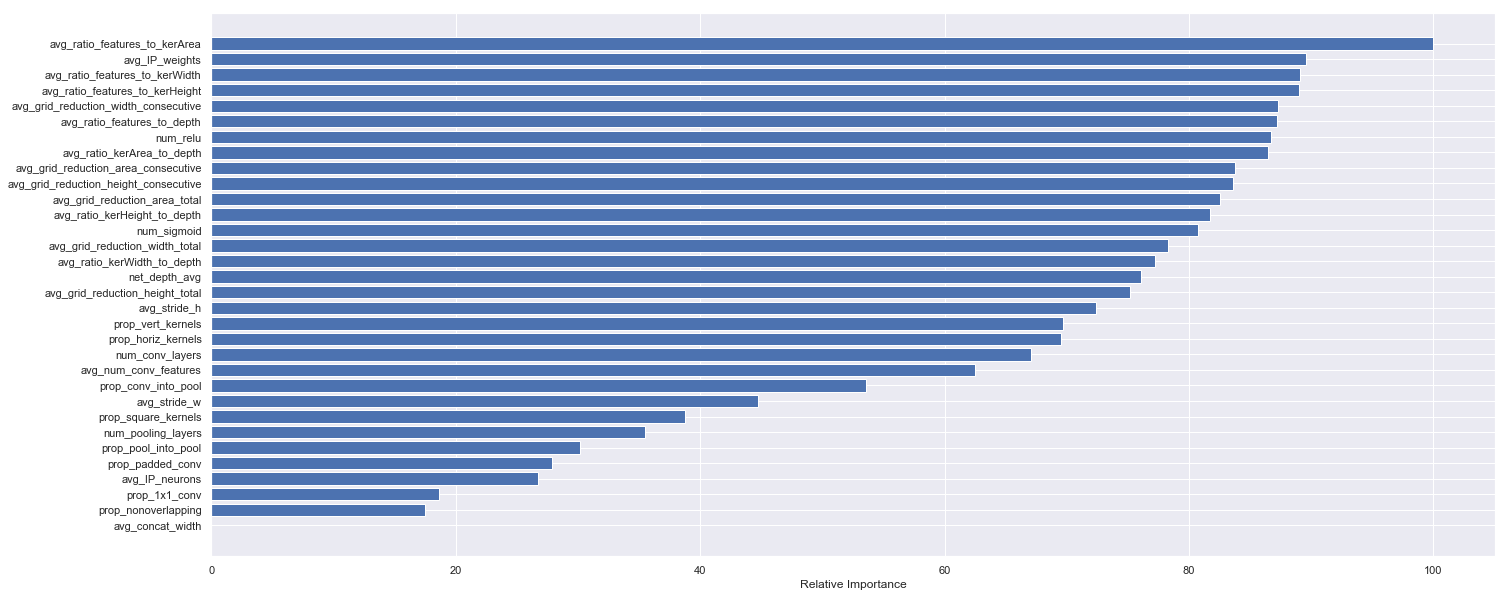

In [98]:
#Explore random forest
rf = RandomForestClassifier(n_estimators=1000, max_depth = None, 
                            bootstrap = False, warm_start = True, random_state=0)

rf.fit(X1_train, y_train)

print("Accuracy : %f" % rf.score(X1_test, y_test))

feature_importance = rf.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

Features_importance_rf = pd.DataFrame({'Feature':X_normed.columns,'Importance':feature_importance})

Sorted_Features_importance_rf = Features_importance_rf.sort_values(by=['Importance'])

pos = np.arange(Features_importance_rf.shape[0]) + .5

fig = plt.figure(figsize = [23,10])
plt.barh(pos, Sorted_Features_importance_rf['Importance'], align='center')
plt.yticks(pos, Sorted_Features_importance_rf['Feature'])
plt.xlabel('Relative Importance')
plt.savefig('RF-variable-significance.png')
plt.show()

Accuracy : 0.717031


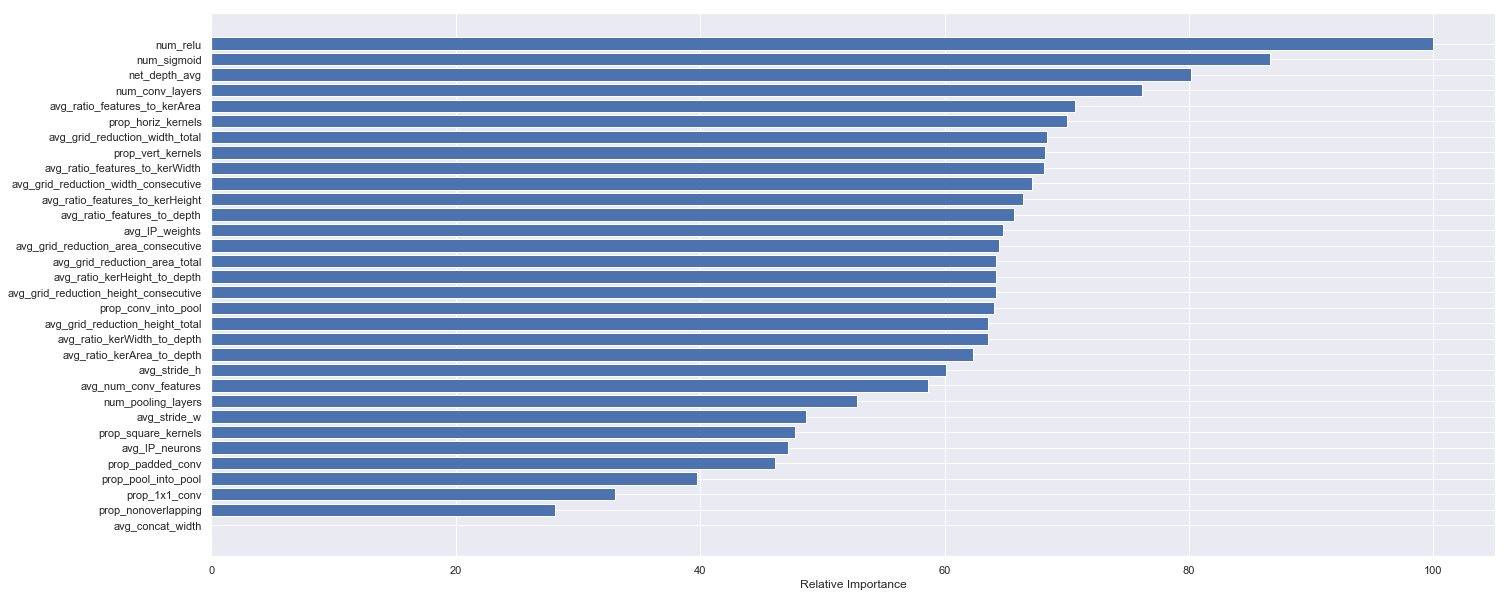

In [12]:
# Explore Extremely Randomized Tree
ex = ExtraTreesClassifier(n_estimators=1000, random_state=0,
                          warm_start=True, n_jobs = 3)
ex.fit(X_train, y_train)

print("Accuracy : %f" % ex.score(X_test, y_test))

feature_importance = ex.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

Features_importance_rf = pd.DataFrame({'Feature':X_normed.columns,'Importance':feature_importance})

Sorted_Features_importance_rf = Features_importance_rf.sort_values(by=['Importance'])

pos = np.arange(Features_importance_rf.shape[0]) + .5

fig = plt.figure(figsize = [23,10])
plt.barh(pos, Sorted_Features_importance_rf['Importance'], align='center')
plt.yticks(pos, Sorted_Features_importance_rf['Feature'])
plt.xlabel('Relative Importance')
plt.savefig('EX-variable-significance.png')
plt.show()

In [ ]:
#Explore Gradient Boosting Classifier
gbc = GradientBoostingClassifier(n_estimators=1000, random_state=0, learning_rate = 0.01,
                                 warm_start = True)
gbc.fit(X_train, y_train)

print("Accuracy : %f" % gbc.score(X_test, y_test))

feature_importance = gbc.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

Features_importance_rf = pd.DataFrame({'Feature':X_normed.columns,'Importance':feature_importance})

Sorted_Features_importance_rf = Features_importance_rf.sort_values(by=['Importance'])

pos = np.arange(Features_importance_rf.shape[0]) + .5

fig = plt.figure(figsize = [23,10])
plt.barh(pos, Sorted_Features_importance_rf['Importance'], align='center')
plt.yticks(pos, Sorted_Features_importance_rf['Feature'])
plt.xlabel('Relative Importance')
plt.savefig('GBC-variable-significance.png')
plt.show()

## Further Dimentionality reduction effort from output of best-performing models

In [7]:
#For resusability

#Read in normalized features
df_normed = pd.read_csv('/Users/duc_hoang/Box Sync/Fermilab Summer Research/Analysis_Scripts/Main data/GA_data/normalized_all_GA_simple_attributes.csv', index_col = 0)

X_normed = df_normed.drop(['initial_accuracy', 'final_accuracy', 'genealogy'],axis=1)

In [5]:
X_normed.columns

Index(['net_depth_avg', 'num_conv_layers', 'num_pooling_layers',
       'avg_IP_neurons', 'avg_IP_weights', 'avg_concat_width',
       'avg_num_conv_features', 'prop_conv_into_pool', 'prop_pool_into_pool',
       'prop_padded_conv', 'prop_1x1_conv', 'prop_square_kernels',
       'prop_horiz_kernels', 'prop_vert_kernels', 'num_relu', 'num_sigmoid',
       'avg_grid_reduction_area_consecutive',
       'avg_grid_reduction_height_consecutive',
       'avg_grid_reduction_width_consecutive', 'avg_grid_reduction_area_total',
       'avg_grid_reduction_height_total', 'avg_grid_reduction_width_total',
       'prop_nonoverlapping', 'avg_stride_h', 'avg_stride_w',
       'avg_ratio_features_to_depth', 'avg_ratio_features_to_kerArea',
       'avg_ratio_features_to_kerWidth', 'avg_ratio_features_to_kerHeight',
       'avg_ratio_kerArea_to_depth', 'avg_ratio_kerWidth_to_depth',
       'avg_ratio_kerHeight_to_depth'],
      dtype='object')

In [18]:
X_normed = X_normed[['net_depth_avg','num_conv_layers', 'num_relu', 'num_sigmoid',  'avg_ratio_features_to_kerArea',  'avg_ratio_features_to_kerWidth', 'avg_ratio_features_to_kerHeight','avg_grid_reduction_area_total','avg_grid_reduction_width_consecutive']]

In [52]:
#Try PCA
pca = PCA(3)
projected = pca.fit_transform(X_normed)

#Check
print(X_normed.shape)
print(projected.shape)

(56452, 9)
(56452, 3)


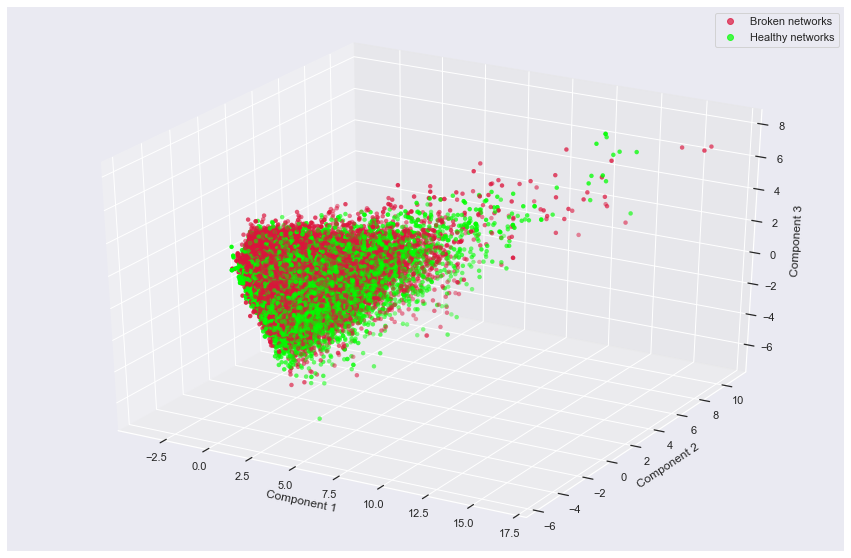

In [53]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.045 else 'lime' for x in df_normed['final_accuracy']]

#Plot the PCA analysis for GA
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(projected[:,0], projected[:,1], projected[:,2], c=colors, edgecolor='none',
           marker='o')

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.savefig('PCD-3D-GA.png')

plt.show()

(56452, 8)
(56452, 2)


Text(99.875, 0.5, 'Component 2')

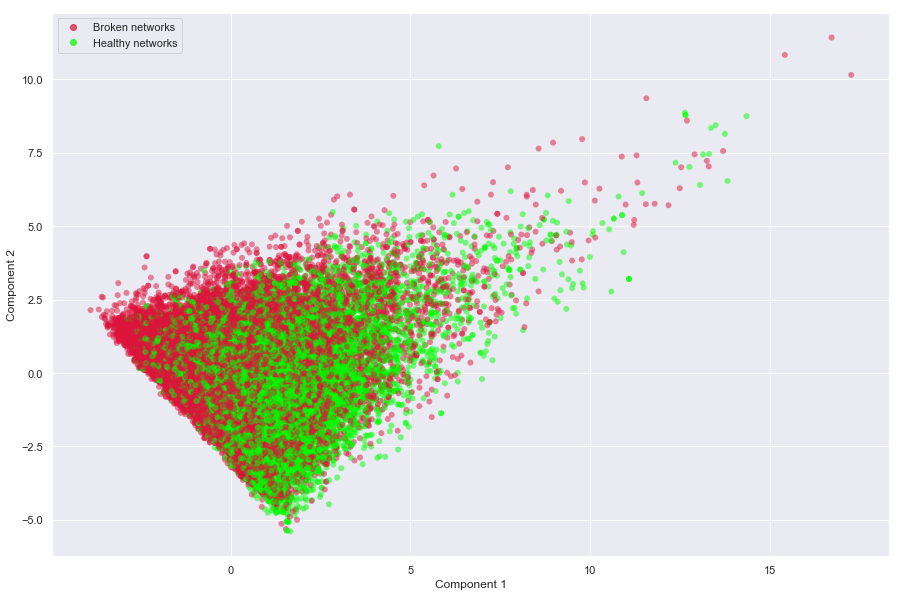

In [45]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected1 = pca.fit_transform(X_normed)

#Check
print(X_normed.shape)
print(projected1.shape)

fig = plt.figure(figsize=[15,10])
plt.scatter(projected1[:, 0], projected1[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------
plt.savefig('PCD-2D-GA.png')

plt.xlabel('Component 1')
plt.ylabel('Component 2')

In [54]:
# The default of 1,000 iterations gives fine results, but I'm training for longer just to eke
# out some marginal improvements. NB: This takes almost an hour!
tsne = TSNE(perplexity=50, metric= 'correlation')

trans = tsne.fit_transform(X_normed)

#Get the colors based on final_accuracy
colors = ['crimson' if row < 0.0045 else 'lime' for row in df_normed['final_accuracy']]

#Plot the transformed data
plt.scatter(trans[:, 0], trans[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Very low accuracy', alpha = 0.7)
high_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Normal accuracy', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, high_accuracy_legend])
# ----------------------

KeyboardInterrupt: 

In [66]:
#Try Locally Linear Embedding
print("Computing LLE embedding ...")
X_r, err = manifold.locally_linear_embedding(X_normed, n_neighbors=12,
                                             n_components=2)
print("Done. Reconstruction error: %g" % err)

Computing LLE embedding ...
Done. Reconstruction error: 4.32933e-15


In [67]:
X_r.shape

(56452, 2)

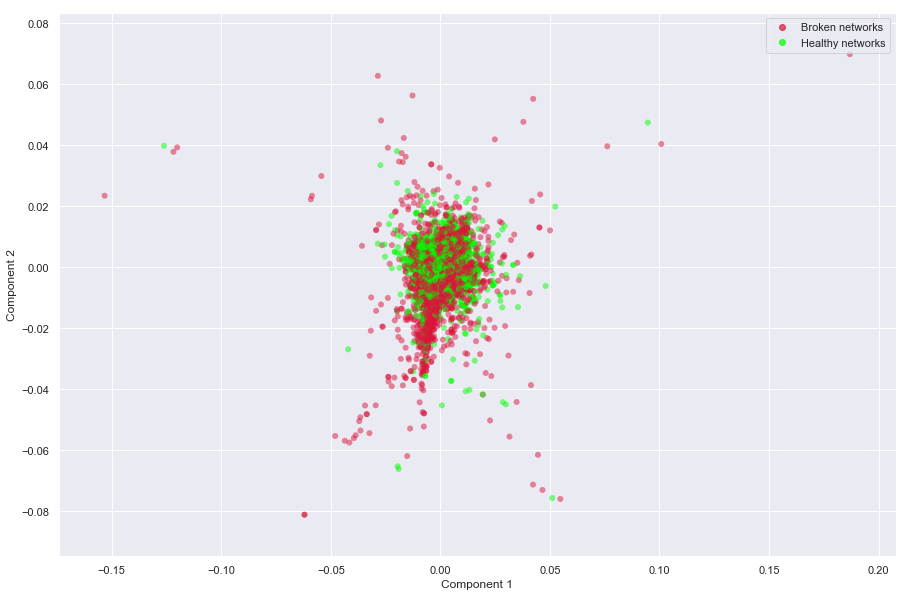

In [68]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.045 else 'lime' for x in df_normed['final_accuracy']]

fig = plt.figure(figsize=[15,10])
plt.scatter(X_r[:, 0], X_r[:, 1],
            color = colors, edgecolor='none', alpha=0.5)

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

plt.xlabel('Component 1')
plt.ylabel('Component 2')

plt.show()

In [ ]:
#Try Isomap
ISOMAP = Isomap(n_components = 3)
X_transformed = ISOMAP.fit_transform(X_normed)

In [ ]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.045 else 'lime' for x in df_normed['final_accuracy']]

#Plot the PCA analysis for GA
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_transformed[:,0], X_transformed[:,1], X_transformed[:,2], c=colors, edgecolor='none',
           marker='o')

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.savefig('PCD-3D-GA.png')

plt.show()

In [1]:
#Try random tree embeddings

In [13]:
from sklearn import decomposition

In [31]:
# ----------------------------------------------------------------------
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=10, random_state=0)
X_transformed = hasher.fit_transform(X_normed)
pca = decomposition.TruncatedSVD(n_components=3)
X_reduced = pca.fit_transform(X_transformed)

Computing Totally Random Trees embedding


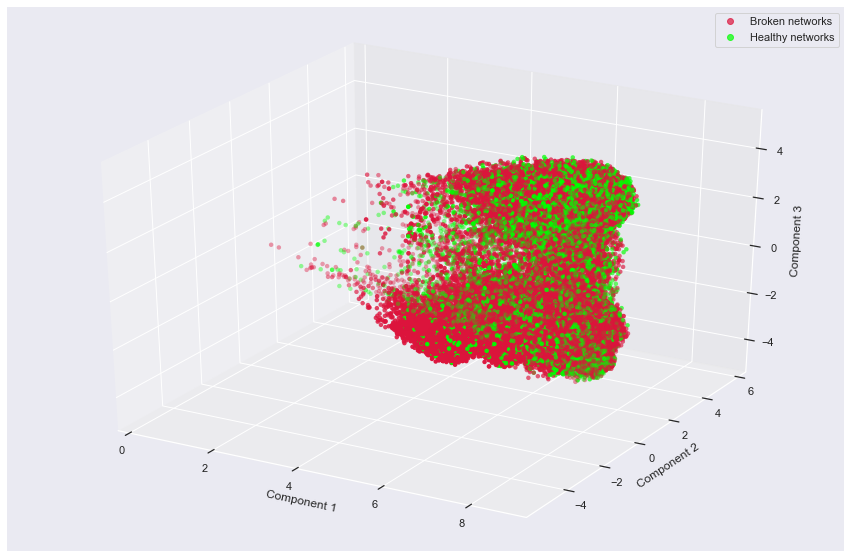

In [30]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.1 else 'lime' for x in df_normed['final_accuracy']]

#Plot the PCA analysis for GA
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c=colors, edgecolor='none',
           marker='o')

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.savefig('PCD-3D-GA.png')

plt.show()

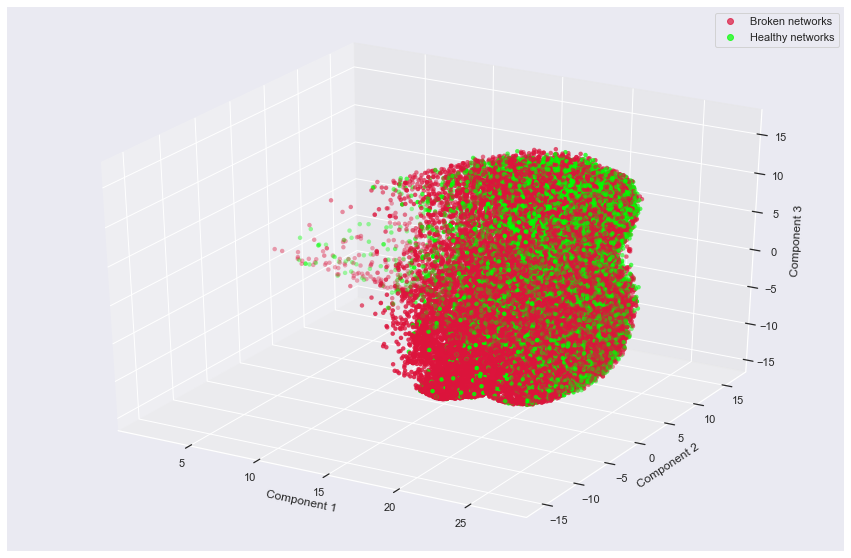

In [24]:
#Get the colors based on final_accuracy
colors = ['crimson' if x < 0.1 else 'lime' for x in df_normed['final_accuracy']]

#Plot the PCA analysis for GA
fig = plt.figure(figsize=[15,10])
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_reduced[:,0], X_reduced[:,1], X_reduced[:,2], c=colors, edgecolor='none',
           marker='o')

#Manually add in legend
low_accuracy_legend = mlines.Line2D([], [], color='crimson', marker='o', linestyle='None',
                                    markersize=6, label='Broken networks', alpha = 0.7)
normal_accuracy_legend = mlines.Line2D([], [], color='lime', marker='o', linestyle='None',
                                    markersize=6, label='Healthy networks', alpha = 0.7)

plt.legend(handles=[low_accuracy_legend, normal_accuracy_legend])
# ----------------------

ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')

plt.show()